# Embedding, LSTM, GRU, Convo1D.
## The main objective is to how to use Keras embedding layers with LSTM, GRU, Convo1D to classify reviews which are converted to sequences.
### Dataset : https://www.kaggle.com/datasets/jessicali9530/kuc-hackathon-winter-2018

## Importing required libraries

In [78]:
import pandas as pd, numpy as np
import warnings
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, GRU, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D

## Loading the dataset

In [79]:
## Reading the data
dtypes = {
    "Unnamed: 0": "int32",
    "drugName": "category",
    "condition": "category",
    "review": "category",
    "rating": "float16",
    "date": "string",
    "usefulCount": "int16",
}
train_df = pd.read_csv(
    r"/kaggle/input/kuc-hackathon-winter-2018/drugsComTrain_raw.csv", quoting=2, dtype=dtypes, on_bad_lines = "skip"
)
train_df = train_df.sample(frac=0.8, random_state=42)
test_df = pd.read_csv(
    r"/kaggle/input/kuc-hackathon-winter-2018/drugsComTest_raw.csv", quoting=2, dtype=dtypes, on_bad_lines = "skip"
)

## Coverting date to date-time format

In [7]:
## Converting date column to datetime format
train_df["date"], test_df["date"] = pd.to_datetime(
    train_df["date"], format="%d-%b-%y"
), pd.to_datetime(test_df["date"], format="%d-%b-%y")


## Creating labels

In [14]:
## Creating labels
new = train_df['rating']
labels = -1*(new <= 4) + 1*(new >= 7)
train_df['label'] = labels


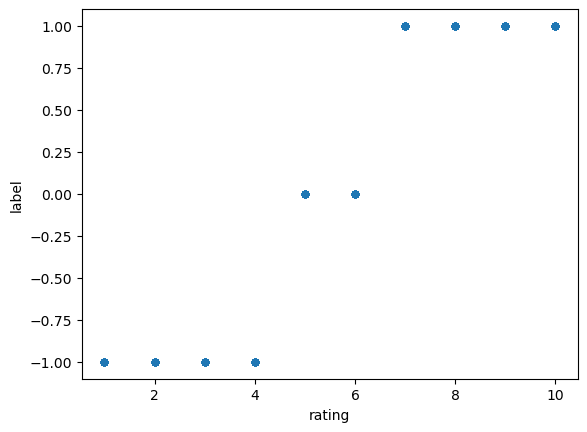

In [16]:
## Check ratings to labels
train_df.plot(x = 'rating', y = 'label', kind = 'scatter')
plt.show()



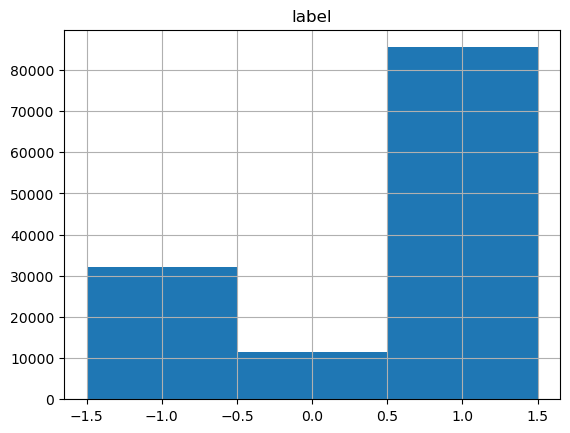

In [24]:
## Create a plot for distribution of labels
train_df.hist(column = 'label', bins = np.arange(-1, 3), align = 'left');

In [30]:
## Creating a new column review_length
train_df['review_length'] = train_df['review'].apply(len)
train_df['review_length'].describe()

count    129038.000000
mean        458.256963
std         243.094715
min           3.000000
25%         262.000000
50%         455.000000
75%         691.000000
max       10787.000000
Name: review_length, dtype: float64

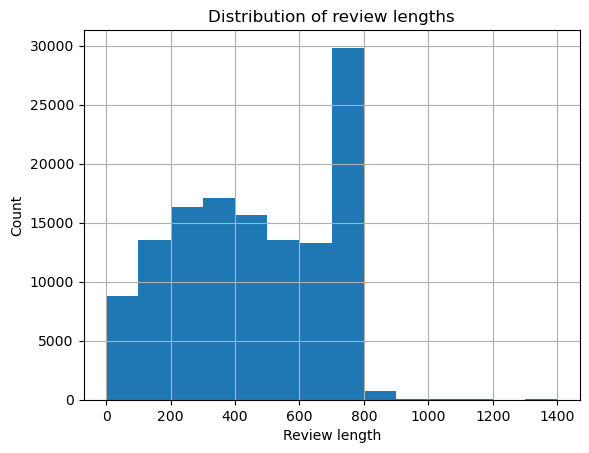

In [31]:
## Creating a plot for distribution of review lengths
train_df.hist('review_length', bins = np.arange(0, 1500, 100));
plt.title('Distribution of review lengths')
plt.xlabel('Review length')
plt.ylabel('Count')
plt.show()

## Converting Reviews to Padding Sequences

In [34]:
## Converting reviews to padding sequences
WORDS = 1000
LENGTH = 100
N = 10000
DEPTH = 32

samples = train_df['review'].iloc[:N]
tokenizer = Tokenizer(num_words = WORDS)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
data_train = pad_sequences(sequences, maxlen = LENGTH)

In [36]:
## Converting labels to one-hot-categorical values
one_hot_labels = to_categorical(labels[:N], num_classes = 3)

In [42]:
## Checking the shape 
data_train.shape, one_hot_labels.shape

((10000, 100), (10000, 3))

## Helper Functions

In [52]:
## Helper functions
def plot_history(history):
    
    fs, ax = plt.subplots(1, 2, figsize = (16, 7))
    
    accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(accuracy) + 1)

    plt.sca(ax[0])
    plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.sca(ax[1])
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()

    plt.show()

In [54]:
## Creating a helper function for model training
def train_model(model, x, y, e = 12, bs = 32, v = 1, vs = 0.25):
    m = model.fit(x, y, epochs = e, batch_size = bs, verbose = v, validation_split = vs)
    return m

## Embedding and Flatten

In [55]:
## First type - Embedding and Flatten
m1 = Sequential()
m1.add(Embedding(WORDS, DEPTH, input_length = LENGTH)) 
m1.add(Flatten())
m1.add(Dense(32, activation = 'relu'))
m1.add(Dense(3, activation = 'softmax'))
m1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           32000     
                                                                 
 flatten_1 (Flatten)         (None, 3200)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                102432    
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 134,531
Trainable params: 134,531
Non-trainable params: 0
_________________________________________________________________


Epoch 1/12
235/235 [==============================] - 2s 4ms/step - loss: 0.7935 - acc: 0.6772 - val_loss: 0.7182 - val_acc: 0.6884
Epoch 2/12
235/235 [==============================] - 1s 4ms/step - loss: 0.5929 - acc: 0.7737 - val_loss: 0.6698 - val_acc: 0.7408
Epoch 3/12
235/235 [==============================] - 1s 4ms/step - loss: 0.4472 - acc: 0.8279 - val_loss: 0.7008 - val_acc: 0.7460
Epoch 4/12
235/235 [==============================] - 1s 4ms/step - loss: 0.2955 - acc: 0.8992 - val_loss: 0.7718 - val_acc: 0.7356
Epoch 5/12
235/235 [==============================] - 1s 4ms/step - loss: 0.1729 - acc: 0.9475 - val_loss: 0.9135 - val_acc: 0.7200
Epoch 6/12
235/235 [==============================] - 1s 4ms/step - loss: 0.0936 - acc: 0.9751 - val_loss: 1.1134 - val_acc: 0.7060
Epoch 7/12
235/235 [==============================] - 1s 4ms/step - loss: 0.0512 - acc: 0.9853 - val_loss: 1.3319 - val_acc: 0.6976
Epoch 8/12
235/235 [==============================] - 1s 4ms/step - loss: 0.

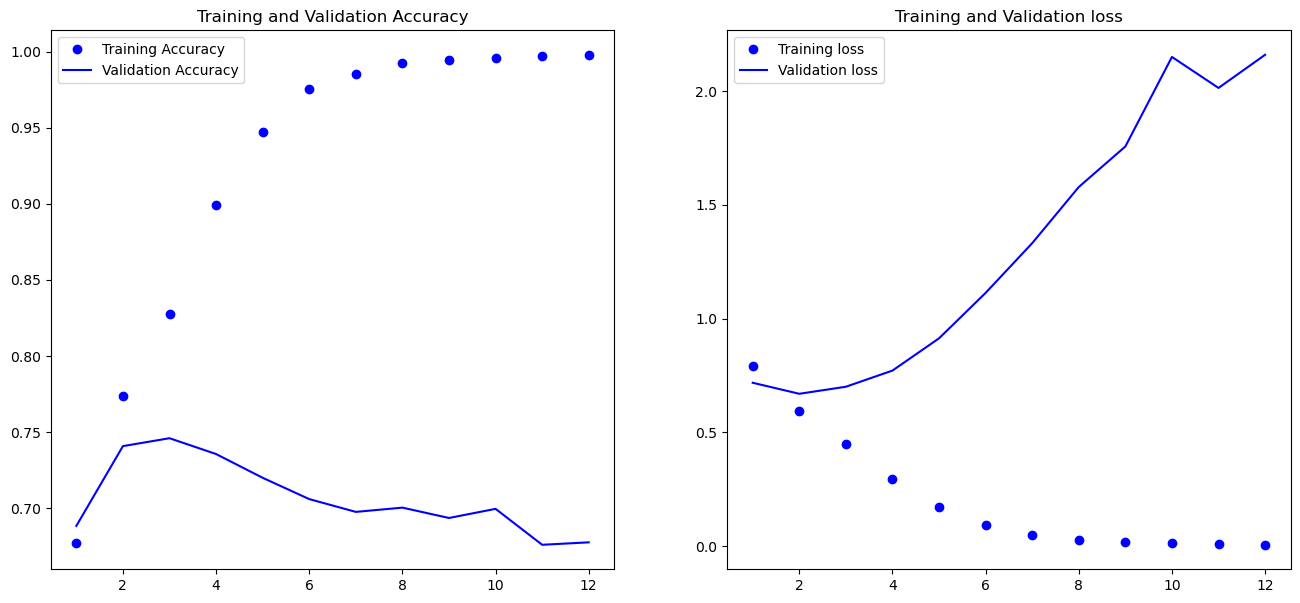

In [56]:
# Train the first type and plot the history
h1 = train_model(m1, data_train, one_hot_labels)
plot_history(h1)

## Embedding and LSTM

In [59]:
# Second type - Embedding and LSTM 
m2 = Sequential()
m2.add(Embedding(WORDS, DEPTH, input_length = LENGTH))
m2.add(LSTM(DEPTH))
m2.add(Dense(3, activation = 'softmax'))
m2.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 32)           32000     
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense_6 (Dense)             (None, 3)                 99        
                                                                 
Total params: 40,419
Trainable params: 40,419
Non-trainable params: 0
_________________________________________________________________


Epoch 1/12
235/235 [==============================] - 10s 44ms/step - loss: 0.4408 - acc: 0.8360 - val_loss: 0.7885 - val_acc: 0.7496
Epoch 2/12
235/235 [==============================] - 10s 43ms/step - loss: 0.4261 - acc: 0.8444 - val_loss: 0.7201 - val_acc: 0.7552
Epoch 3/12
235/235 [==============================] - 10s 43ms/step - loss: 0.4166 - acc: 0.8480 - val_loss: 0.8242 - val_acc: 0.6904
Epoch 4/12
235/235 [==============================] - 10s 44ms/step - loss: 0.4052 - acc: 0.8505 - val_loss: 0.7476 - val_acc: 0.7236
Epoch 5/12
235/235 [==============================] - 10s 43ms/step - loss: 0.3913 - acc: 0.8555 - val_loss: 0.9565 - val_acc: 0.6908
Epoch 6/12
235/235 [==============================] - 10s 43ms/step - loss: 0.3816 - acc: 0.8621 - val_loss: 0.7750 - val_acc: 0.7212
Epoch 7/12
235/235 [==============================] - 10s 44ms/step - loss: 0.3699 - acc: 0.8636 - val_loss: 0.7656 - val_acc: 0.7376
Epoch 8/12
235/235 [==============================] - 10s 43ms

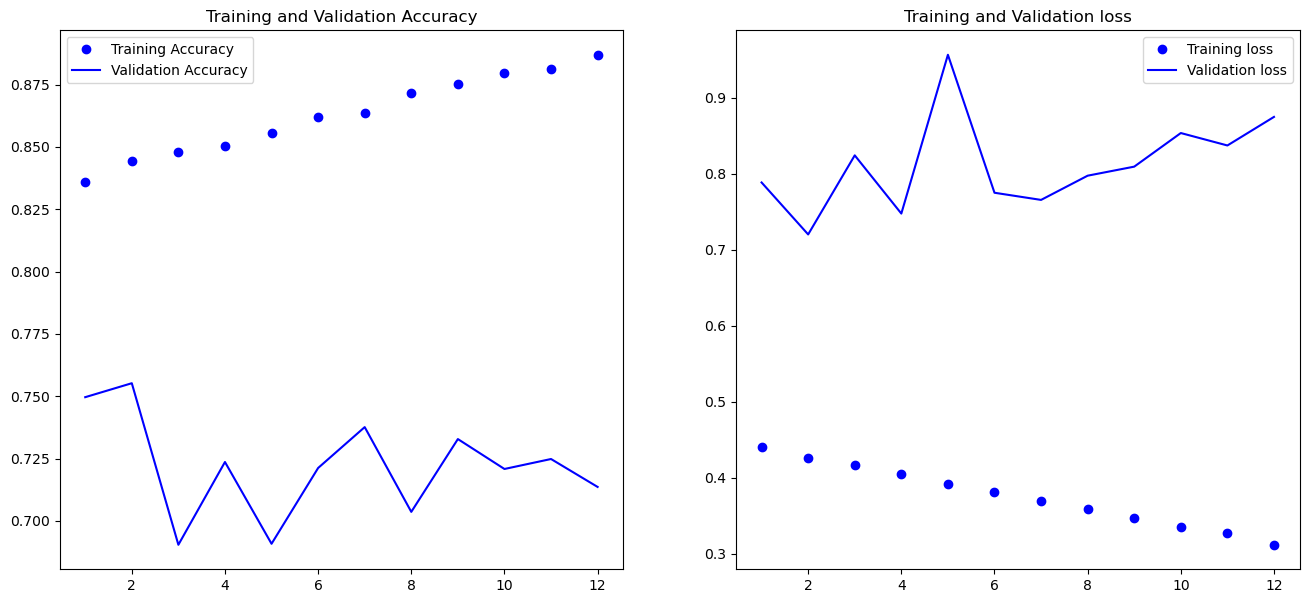

In [62]:
# Train the second type and plot the history
h2 = train_model(m2, data_train, one_hot_labels)
plot_history(h2)

## Embedding and GRU

In [65]:
## Third type - Embedding and GRU 
m3 = Sequential()
m3.add(Embedding(WORDS, DEPTH, input_length = LENGTH))
m3.add(GRU(LENGTH))
m3.add(Dense(3, activation = 'softmax'))
m3.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 32)           32000     
                                                                 
 gru (GRU)                   (None, 100)               40200     
                                                                 
 dense_7 (Dense)             (None, 3)                 303       
                                                                 
Total params: 72,503
Trainable params: 72,503
Non-trainable params: 0
_________________________________________________________________


Epoch 1/12
235/235 [==============================] - 18s 67ms/step - loss: 0.8114 - acc: 0.6708 - val_loss: 0.7445 - val_acc: 0.6944
Epoch 2/12
235/235 [==============================] - 15s 63ms/step - loss: 0.6874 - acc: 0.7264 - val_loss: 0.6627 - val_acc: 0.7388
Epoch 3/12
235/235 [==============================] - 15s 65ms/step - loss: 0.6324 - acc: 0.7567 - val_loss: 0.6473 - val_acc: 0.7544
Epoch 4/12
235/235 [==============================] - 15s 63ms/step - loss: 0.6040 - acc: 0.7672 - val_loss: 0.6355 - val_acc: 0.7568
Epoch 5/12
235/235 [==============================] - 15s 65ms/step - loss: 0.5771 - acc: 0.7821 - val_loss: 0.7749 - val_acc: 0.6784
Epoch 6/12
235/235 [==============================] - 15s 63ms/step - loss: 0.5643 - acc: 0.7868 - val_loss: 0.6545 - val_acc: 0.7528
Epoch 7/12
235/235 [==============================] - 15s 64ms/step - loss: 0.5474 - acc: 0.7928 - val_loss: 0.6856 - val_acc: 0.7352
Epoch 8/12
235/235 [==============================] - 15s 64ms

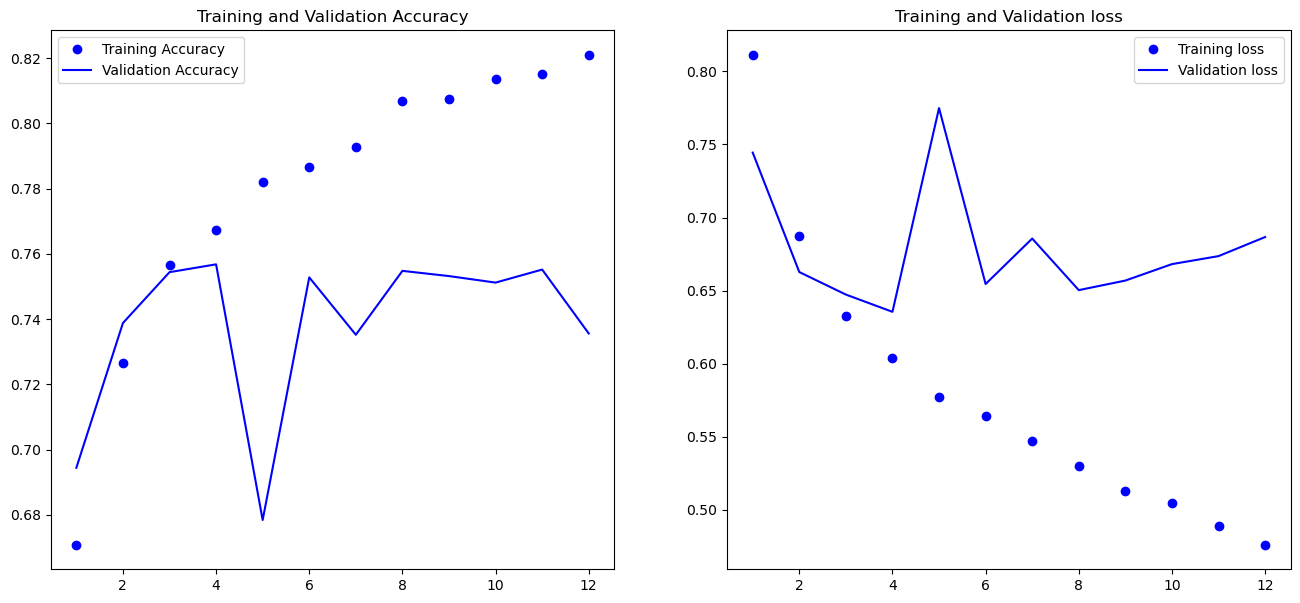

In [67]:
## Train the third type and plot the history
h3 = train_model(m3, data_train, one_hot_labels)
plot_history(h3)

## Embedding with Conv1D & MaxPooling1D 

In [70]:
## Fourth type - Embedding with Conv1D & MaxPooling1D 
m4 = Sequential()
m4.add(Embedding(WORDS, DEPTH, input_length = LENGTH))
m4.add(Conv1D(DEPTH, 7, activation = 'relu'))
m4.add(MaxPooling1D(5))
m4.add(Conv1D(DEPTH, 7, activation = 'relu'))
m4.add(GlobalMaxPooling1D())
m4.add(Dense(3, activation = 'softmax'))
m4.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 32)           32000     
                                                                 
 conv1d (Conv1D)             (None, 94, 32)            7200      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 32)            7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_8 (Dense)             (None, 3)                

Epoch 1/12
235/235 [==============================] - 3s 9ms/step - loss: 0.8195 - acc: 0.6647 - val_loss: 0.7721 - val_acc: 0.6668
Epoch 2/12
235/235 [==============================] - 2s 9ms/step - loss: 0.7037 - acc: 0.7161 - val_loss: 0.7035 - val_acc: 0.7332
Epoch 3/12
235/235 [==============================] - 2s 9ms/step - loss: 0.6293 - acc: 0.7597 - val_loss: 0.7104 - val_acc: 0.7248
Epoch 4/12
235/235 [==============================] - 2s 8ms/step - loss: 0.5841 - acc: 0.7764 - val_loss: 0.6803 - val_acc: 0.7408
Epoch 5/12
235/235 [==============================] - 2s 8ms/step - loss: 0.5427 - acc: 0.7961 - val_loss: 0.6800 - val_acc: 0.7384
Epoch 6/12
235/235 [==============================] - 2s 10ms/step - loss: 0.4948 - acc: 0.8161 - val_loss: 0.6878 - val_acc: 0.7444
Epoch 7/12
235/235 [==============================] - 2s 8ms/step - loss: 0.4409 - acc: 0.8336 - val_loss: 0.7169 - val_acc: 0.7460
Epoch 8/12
235/235 [==============================] - 2s 9ms/step - loss: 0

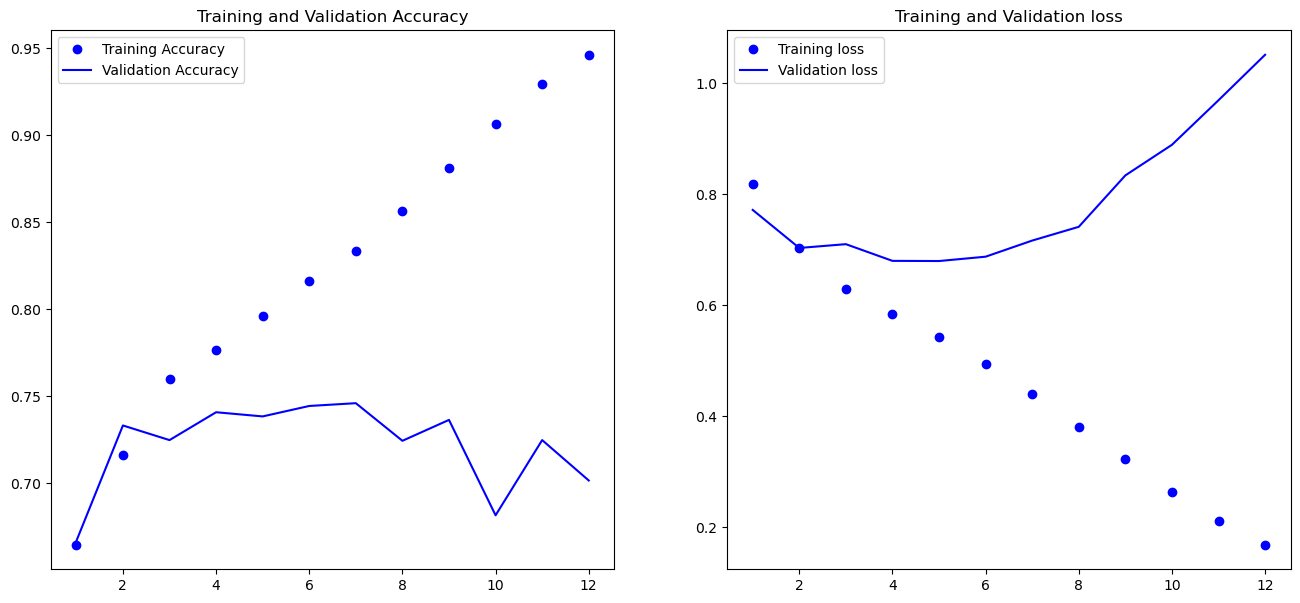

In [72]:
## Train the fourth type and plot the history
h4 = train_model(m4, data_train, one_hot_labels)
plot_history(h4)

## Embedding with mixed Conv1D and GRU

In [73]:
# Fifth type - Embedding with mixed Conv1D and GRU
m5 = Sequential()
m5.add(Embedding(WORDS, DEPTH, input_length = LENGTH))
m5.add(Conv1D(DEPTH, 5, activation = 'relu'))
m5.add(MaxPooling1D(5))
m5.add(Conv1D(DEPTH, 7, activation = 'relu'))
m5.add(GRU(DEPTH, dropout = 0.1, recurrent_dropout = 0.5))
m5.add(Dense(3, activation = 'softmax'))
m5.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m5.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 32)           32000     
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 32)            5152      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 19, 32)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 13, 32)            7200      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense_9 (Dense)             (None, 3)                 99        
                                                      

Epoch 1/12
235/235 [==============================] - 5s 20ms/step - loss: 0.7992 - acc: 0.6697 - val_loss: 0.7207 - val_acc: 0.7064
Epoch 2/12
235/235 [==============================] - 4s 19ms/step - loss: 0.6642 - acc: 0.7383 - val_loss: 0.6706 - val_acc: 0.7440
Epoch 3/12
235/235 [==============================] - 5s 21ms/step - loss: 0.6002 - acc: 0.7709 - val_loss: 0.7220 - val_acc: 0.7356
Epoch 4/12
235/235 [==============================] - 4s 19ms/step - loss: 0.5533 - acc: 0.7887 - val_loss: 0.6453 - val_acc: 0.7556
Epoch 5/12
235/235 [==============================] - 4s 18ms/step - loss: 0.4895 - acc: 0.8175 - val_loss: 0.7808 - val_acc: 0.7016
Epoch 6/12
235/235 [==============================] - 4s 19ms/step - loss: 0.4089 - acc: 0.8492 - val_loss: 0.6802 - val_acc: 0.7532
Epoch 7/12
235/235 [==============================] - 4s 19ms/step - loss: 0.3324 - acc: 0.8793 - val_loss: 0.7610 - val_acc: 0.7468
Epoch 8/12
235/235 [==============================] - 5s 20ms/step - 

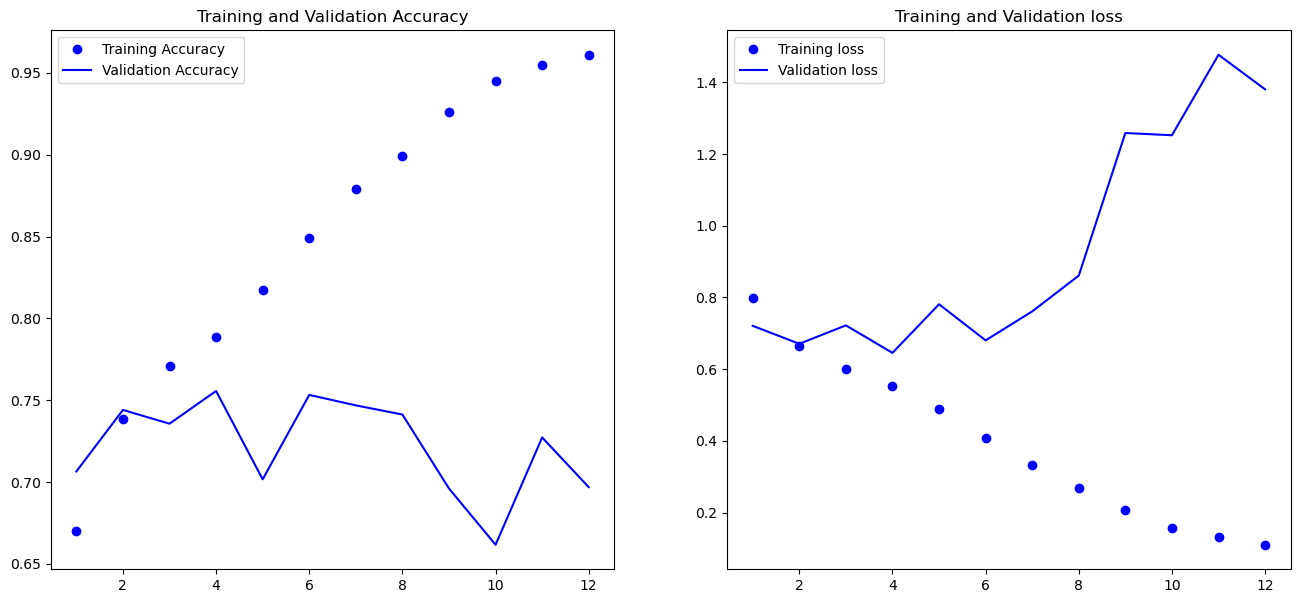

In [75]:
## Train the fifth type and plot the history
h5 = train_model(m5, data_train, one_hot_labels)
plot_history(h5)